# Topic Modelling for Massachusetts

In [2]:
# Set tag so gensim doesn't throw an error
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# Handle imports
import numpy as np
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pyLDAvis.gensim_models as gensimvis
from tqdm import tqdm_notebook as tqdm

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Load data
df = pd.read_csv("Standardized Data/MA_Final_cleaned.csv")

## Text Cleaning and Preprocessing

In [6]:
# Manually updated list of stopwords
stop_word_list = [
   
    'applicable',
    'understands',
    'commissioner',
    'licensing',
    'regulation',
    'person',
    'engage',
    'general',
    'article',
    'organization',
    'secretary',
    'commonwealth',
    'commerce,'
    'commence',
    'abovecaptioned',
    'stipulate',
    'consent',
    'docket',
    'divisions',
    'massachusetts',
    'ma',
    'cmr',
    'bank',
    'federal',
    'mortgage',
    'division',
    'order',
    'chapter',
    'section',
    'state',
    'law',
    'date',
    'paragraph',
    'record',
    'sign',
    'act',
    'federal',
    'secure',
    'enforcement',
    'nmls',
    'finding',
    'fact',
    'page',
    'general',
    'standard',
    'warrant',
    'condition',
    'information',
    'time',
    'jurisdiction',
    'a',
    'b',
    'd',
    'e',
    'f',
    'g',
    'h',
    'i',
    'k',
    'c'
    'safe',
    'faqs',
    'faq',
    'notify',
    'intent',
    'party',
    'matter',
    'agree',
    'follow',
    'settlement',
    'agreement',
    'report',
    'recommendation',
    'administrative',
    'court',
    'remain',
    'effective',
    'immediately',
    'issuance',
    'provision',
    'warranty',
    'enforceable',
    'satisfy',
    'penalty',
    'pursuant',
    'dollar',
    'assess',
    'consideration',
    'set',
    'promise',
    'resolution',
    'representation',
    'aside',
    'competent',
    'include',
    'limit',
    'set',
    'promise',
    'resolution',
    'representation',
    'aside',
    'competent',
    'conclusion',
    'base',
    'far',
    'forth',
    'present',
    'sufficient',
    'temporary',
    'cease',
    'desist',
    'terminate',
    'application',
    'issue',
    'refuse',
    'revocation',
    'contain',
    'determine',
    'streamlined',
    'renewal',
    'process',
    'indicate',
    'statement',
    'corporation',
    'stipulation',
    'broker',
    'licensee',
    'applicant',
    'business',
    'lender',
    'corporate',
    'authorize',
    'regulatory'
    'amendment',
    'licensed',
    'statute',
    'entity',
    'surety'
]


In [7]:
# Prepare Lemmatizers and Stop Words
nlp = spacy.load('en_core_web_lg')
lemmatizer = nlp.get_pipe("lemmatizer")
nlp.Defaults.stop_words.update(stop_word_list)
# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True
lemma_tags = {"NNS", "NNPS"}


In [8]:
# Function to clean text
def clean_text(sample_text):
    sample_text = sample_text.translate(str.maketrans('', '', string.punctuation))
    sample_text = " ".join([w for w in sample_text.split() if not w.isdigit()])
    sample_text = sample_text.lower()
    doc = nlp(sample_text)
    doc = [token.lemma_ for token in doc if (token.tag_ in lemma_tags or token.lemma_ != '-PRON-' and token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV'])]
    doc = u' '.join(doc)
    doc = nlp.make_doc(doc)
    tokens = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return tokens

In [9]:
sample_text = df.loc[0,"Text"]
print(clean_text(sample_text))
print(len(clean_text(sample_text)))

['relevant', 'organize', 'locate', 'accord', 'submit', 'maintain', 'file', 'license', 'require', 'hold', 'license', 'number', 'mb0624', 'expire', 'correspondence', 'consumer', 'collectively', 'borrower', 'request', 'borrower', 'complete', 'enclose', 'loan', 'residential', 'property', 'locate', 'provide', 'additional', 'borrower', 'review', 'copy', 'correspondence', 'receive', 'borrower', 'attach', 'exhibit', 'correspondence', 'current', 'rate', 'fix', 'term', 'currently', 'lock', 'letter', 'request', 'consumer', 'return', 'form', 'enclose', 'obtain', 'borrower', 'submit', 'complete', 'loan', 'additional', 'material', 'request', 'place', 'borrower', 'qualified', 'loan', 'term', 'correspondence', 'reference', '255e', 'define', 'compensation', 'gain', 'expectation', 'compensation', 'gain', 'directly', 'indirectly', 'negotiate', 'place', 'assist', 'placement', 'find', 'offer', 'negotiate', 'place', 'assist', 'placement', 'find', 'loan', 'residential', 'property', '255e', 'prohibit', 'activ

In [10]:
sample_text

", through the Commissioner, has jurisdiction over the licensing and regulation of persons engaged in the business of a mortgage broker pursuant to Massachusetts General Laws chapter 255E, section 2.  Mortgage One is, and at all relevant times has been, a corporation organized under the laws of the Commonwealth of Massachusetts. Mortgage One is located at 1408 Providence Highway, Norwood, Massachusetts, 02062, according to records submitted by Mortgage One and maintained on file with the Division.  Mortgage One is licensed by the Commissioner as a mortgage broker as required by General Laws chapter 255E, section 2. Mortgage One holds mortgage broker license number MB0624 which is set to expire on May 31, 2004.  On or about June 17, 2003, Mortgage One issued correspondence to two Massachusetts consumers, Andrew Klane and Suzanne Klane (collectively, the borrower), requesting that the borrower complete the enclosed mortgage loan application for a residential property located in Massachus

In [11]:
# Clean Text
text = df["Text"]
text_list = []
for doc in tqdm(text):
    if not pd.isna(doc):
        pr = clean_text(doc)
        text_list.append(pr)

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/323 [00:00<?, ?it/s]

In [12]:
# Store word_list in txt file for easier reference

with open('ma_text_list.txt','w',encoding='UTF-8') as file:
    file.writelines("%s\n" % text for text in text_list)

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(text_list, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[text_list], threshold=30) 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
grammed_list = [trigram_mod[bigram_mod[doc]]for doc in text_list]
print(trigram_mod[bigram_mod[text_list[8]]])

['255e', 'mulberry', 'relevant', 'license', 'require', '255e', 'mulberry', 'initial', 'license', 'accord', 'maintain', 'file', 'mulberry', 'maintain', 'additional', 'location', 'conduct', 'accordance', '255e', 'mulberry', 'obtain', 'maintain', 'license', 'number', 'mb2508', 'respectively', 'additional', 'location', 'relevant', 'treasurer', 'director', 'principal', 'stockholder', 'mulberry', 'accord', 'annual', 'year', 'end', 'submit', 'mulberry', 'employ', 'mulberry', 'parttime', 'basis', 'grand_jury', 'impanel', 'district', 'return_indictment', 'individual', 'defendant', 'charge', 'sixtytwo', 'count', 'wire', 'fraud', 'count', 'conspiracy', 'launder', 'money', 'arise', 'participation', 'multimillion', 'fraud', 'scheme', 'individual', 'charge', 'grand_jury', 'indictment', 'charge', 'grand_jury', 'indictment', 'allege', 'defendant', 'participate', 'scheme', 'purchase', 'distressed', 'property', 'rapidly', 'resell', 'property', 'artificially', 'inflate', 'value', 'practice', 'generally',

## HDP Model to determine suitable range of choices for Topic Modelling

In [14]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(text_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in text_list]

In [15]:
# Creates, which is a mapping of word IDs to words.
grammed_words = corpora.Dictionary(grammed_list)

# Turns each document into a bag of words.
grammed_corpus = [grammed_words.doc2bow(doc) for doc in grammed_list]

In [16]:
import tomotopy as tp
import numpy as np

term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw = term_weight, min_cf =5, rm_top = 0, gamma = 1, alpha = 0.1,initial_k = 5, seed = 12)
sum = 0
for text in text_list:
    if len(text) > 0:
        hdp.add_doc(text)
print(sum)
# Initiate sampling burn-in  (i.e. discard N first iterations)
hdp.burn_in = 100
hdp.train(0)
print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs,
      ', Num words:', hdp.num_words)
print('Removed top words:', hdp.removed_top_words)

# Train model
for i in range(0, 1000, 100):
    hdp.train(100) # 100 iterations at a time
    print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))

0
Num docs: 323 , Vocab size: 1302 , Num words: 96444
Removed top words: []
Iteration: 0	Log-likelihood: -5.576251524097714	Num. of topics: 16
Iteration: 100	Log-likelihood: -5.562857381138895	Num. of topics: 17
Iteration: 200	Log-likelihood: -5.550656919239874	Num. of topics: 17
Iteration: 300	Log-likelihood: -5.538664915571466	Num. of topics: 16
Iteration: 400	Log-likelihood: -5.536902129074118	Num. of topics: 17
Iteration: 500	Log-likelihood: -5.528472346167054	Num. of topics: 17
Iteration: 600	Log-likelihood: -5.525672453008294	Num. of topics: 17
Iteration: 700	Log-likelihood: -5.5221088131491305	Num. of topics: 18
Iteration: 800	Log-likelihood: -5.52039776544629	Num. of topics: 19
Iteration: 900	Log-likelihood: -5.519071371855144	Num. of topics: 18


## LDA Topic Modelling

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state = 12)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=words, corpus=corpus, texts=text_list, start=5, limit=25, step=1)

In [19]:
# Can take a long time to run.
grammed_model_list, grammed_coherence_values = compute_coherence_values(dictionary=grammed_words, corpus=grammed_corpus, texts=grammed_list, start=5, limit=25, step=1)

In [20]:
coherence_values

[0.3602107419177532,
 0.351283845454901,
 0.34212974882180985,
 0.33681953920652685,
 0.34019876262173054,
 0.3458648462582731,
 0.33909845460856,
 0.3459053471770733,
 0.33909660397234287,
 0.35063121871728603,
 0.3543251036778335,
 0.3561688318350215,
 0.3599677103005901,
 0.360403019656522,
 0.34917085727219244,
 0.3599587345490492,
 0.3517229681886357,
 0.36155978361695357,
 0.35945314348764634,
 0.3684516673018194]

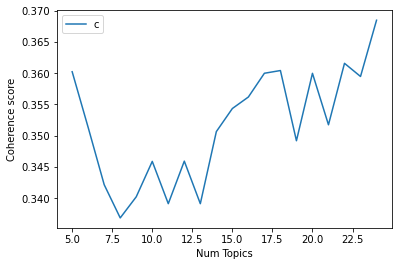

In [21]:
# Show graph
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
grammed_coherence_values

[0.39398092790563133,
 0.3773012903401017,
 0.3764740907484447,
 0.37670815441717,
 0.38971073477810436,
 0.381885884783563,
 0.36806730026948953,
 0.34103817428214916,
 0.3461233766478609,
 0.3442355134183808,
 0.3316197034477655,
 0.3385080063307494,
 0.34108391059073484,
 0.3309936610485,
 0.3213005673647445,
 0.3155758588481351,
 0.33361350161051034,
 0.33101866558028037,
 0.33149859090210976,
 0.3228212819978214]

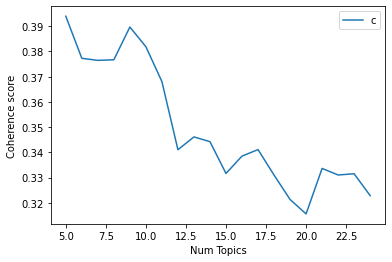

In [24]:
# Show graph
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, grammed_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
model_selected = model_list[13]
# Visualization of Categories

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(model_selected, corpus, words)

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.094064  0.057558       1        1  22.161506
2      0.056853  0.098439       2        1  16.203220
9     -0.018742 -0.028630       3        1  13.956615
12     0.061425  0.005079       4        1   9.093496
5      0.070672 -0.061151       5        1   6.609686
6      0.022791  0.036181       6        1   6.426122
1      0.052481  0.000288       7        1   4.718148
3     -0.102257 -0.036876       8        1   4.514141
16     0.003808  0.021387       9        1   4.187804
4      0.068195 -0.046802      10        1   3.438611
0      0.057231 -0.055194      11        1   2.584238
17    -0.046306 -0.043349      12        1   1.852176
13    -0.057181 -0.025954      13        1   1.509083
7      0.008461  0.033967      14        1   1.104119
11    -0.009152 -0.010384      15        1   0.802486
15    -0.042380  0.035159      16        1   0.470002
8     -0.044404 -0.040556      17        1   0.314291
14     0.012569  0.060836      18        1   0.054255, topic_info=             Term         Freq        Total Category  logprob  loglift
35           loan  3811.000000  3811.000000  Default  30.0000  30.0000
1701         bond  2131.000000  2131.000000  Default  29.0000  29.0000
34        license  2535.000000  2535.000000  Default  28.0000  28.0000
619    originator  1683.000000  1683.000000  Default  27.0000  27.0000
701   requirement  1364.000000  1364.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
12       consumer     0.319962   585.099465  Topic18  -5.1211   0.0079
139     financial     0.322596   639.503613  Topic18  -5.1129  -0.0728
94        failure     0.315068   595.553026  Topic18  -5.1365  -0.0252
168       company     0.315689   665.671392  Topic18  -5.1346  -0.1346
61         submit     0.314015   879.996778  Topic18  -5.1399  -0.4190

[1349 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
447       8  0.502254             12d
2216      1  0.471484  2008conducting
2079      9  0.640455       2009040co
2552      5  0.680895          2029a2
0         1  0.156595            255e
...     ...       ...             ...
424      13  0.017270            year
424      14  0.014803            year
424      15  0.009869            year
424      16  0.002467            year
424      17  0.002467            year

[4938 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 3, 10, 13, 6, 7, 2, 4, 17, 5, 1, 18, 14, 8, 12, 16, 9, 15])

In [30]:
# Visualization of Categories

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
gensimvis.prepare(model_selected, grammed_corpus, grammed_words)

C:\Users\chave\anaconda3\envs\topicmodelling\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.144978 -0.061817       1        1  24.408182
11    -0.104470  0.065878       2        1  15.537931
3      0.006442  0.078067       3        1  12.624483
0      0.046021 -0.016088       4        1  10.964078
2      0.079780 -0.011760       5        1   5.631831
8     -0.052573 -0.012053       6        1   5.359765
15    -0.064611 -0.016096       7        1   4.638473
6      0.039201 -0.030810       8        1   4.415006
16     0.037906 -0.014630       9        1   4.409508
12     0.043499 -0.035565      10        1   3.703008
13     0.033551  0.001466      11        1   2.685427
5     -0.027494 -0.042203      12        1   2.179139
7     -0.063055  0.007265      13        1   1.769748
9      0.090715 -0.020332      14        1   0.674281
1      0.024252 -0.025298      15        1   0.478566
14     0.043329  0.024813      16        1   0.445840
4      0.012485  0.109163      17        1   0.074735, topic_info=            Term         Freq        Total Category  logprob  loglift
30          loan  3291.000000  3291.000000  Default  30.0000  30.0000
29       license  2569.000000  2569.000000  Default  29.0000  29.0000
630   originator  1130.000000  1130.000000  Default  28.0000  28.0000
1895        bond  1921.000000  1921.000000  Default  27.0000  27.0000
2572        safe   431.000000   431.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
44       provide     0.364310  1021.723794  Topic17  -5.1015  -0.7400
55        review     0.282933   611.487082  Topic17  -5.3543  -0.4795
52       require     0.297909  1256.228569  Topic17  -5.3027  -1.1479
33      maintain     0.288558  1000.433507  Topic17  -5.3346  -0.9521
75       conduct     0.273072   676.215586  Topic17  -5.3897  -0.6156

[1259 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2292      1  0.613569  10day_comment
2292      2  0.208175  10day_comment
2292      3  0.010957  10day_comment
2292      4  0.010957  10day_comment
2292      6  0.054783  10day_comment
...     ...       ...            ...
781      12  0.277830   wwwsalarycom
1797      1  0.135697     yeartodate
1797      3  0.135697     yeartodate
1797      4  0.407090     yeartodate
1797      5  0.135697     yeartodate

[4114 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 4, 1, 3, 9, 16, 7, 17, 13, 14, 6, 8, 10, 2, 15, 5])

In [26]:
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [54]:
def format_topics_sentences(ldamodel=model_selected, corpus=corpus, texts=text_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        summary = [0]*6
        print(i)
        for j, (topic_num, prop_topic) in enumerate(row):
            print(j)
            if j == 0:  # => dominant topic
                summary[0]=(int(topic_num))
                summary[1]=(round(prop_topic,4))
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                summary[2]=(topic_keywords)
            elif j == 1:
                summary[3]=(int(topic_num))
                summary[4]=(round(prop_topic,4))
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                summary[5]=(topic_keywords)
            else:
                print(summary)
                sent_topics_df = sent_topics_df.append(pd.Series(summary), ignore_index=True)
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Dominant_Topic_2', 'Perc_Contribution_2', 'Topic_Keywords_2','Text']
    return(sent_topics_df)



df_topic_sents_keywords = format_topics_sentences(ldamodel=model_selected, corpus=grammed_corpus, texts=grammed_list)
df_topic_sents_keywords.loc[100:200]

0
0
1
2
[2, 0.669, 'loan, file, maintain, license, borrower, review, property, provide, consumer, book', 1, 0.2244, 'bond, license, loan, requirement, submit, provide, maintain, file, require, conduct']
1
0
1
2
[2, 0.6865, 'loan, file, maintain, license, borrower, review, property, provide, consumer, book', 5, 0.2907, 'bond, license, require, maintain, requirement, obtain, file, loan, provide, violation']
2
0
1
2
[6, 0.6124, 'loan, license, bond, consumer, maintain, review, file, provide, requirement, require', 4, 0.2988, 'originator, loan, license, safe, requirement, obtain, fail, test, component, provide']
3
0
4
0
1
5
0
6
0
1
7
0
8
0
1
9
0
10
0
11
0
1
12
0
13
0
14
0
15
0
16
0
17
0
18
0
1
2
[2, 0.6638, 'loan, file, maintain, license, borrower, review, property, provide, consumer, book', 8, 0.3165, 'license, loan, bond, require, originator, requirement, submit, fail, provide, file']
19
0
20
0
21
0
1
22
0
23
0
24
0
1
25
0
1
26
0
27
0
28
0
1
29
0
1
30
0
1
31
0
32
0
1
33
0
1
2
[5, 0.5311,

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Dominant_Topic_2,Perc_Contribution_2,Topic_Keywords_2,Text
100,NaN,NaN,NaN,NaN,NaN,NaN,"[255e, findings, loan, originator, relevant, license, failure, obtain, maintain, bond, license, demonstrate, maintain, bond, form, approve, bond, clause_insurance_company, day, prior_cancel, bond_reason_automatically, suspend, license, cancellation_effect_bond, replace_renew_amendment, public_hearing, hold, purpose_afford_interested, opportunity, provide, oral_written_testimony, regard_propose, amendment, bond, requirement, public_hearing, 10day_comment, period, open_finalization_amendment, industry_letter_distribute, provide, advance_notice, substantial_revision_necessity, obtain, bond, findings, license, 7th, require, comply_new, net_worth_bond, requirement, conduct, obtain, bond, violation_cite_consider, failure, obtain, bond, violation, regulatory_bulletin, bond, requirement, obtain, hold, license, establish, maintain, bond, duration, bond, continuous_bonding, company, insurance, company, send_detailed, instruction, regard, license, directive_execute_bond, place_emphasis, original, send, additional, instruction, regard, requirement, instruction, provide, mail_original, notarized, bond, send, notice, file, require, bond, notice, provide, additional, ...]"
101,NaN,NaN,NaN,NaN,NaN,NaN,"[255e, financial, resources, loan, originator, financial, resource, relevant, license, license, demonstrate, maintain, bond, form, approve, bond, clause_insurance_company, day, prior_cancel, bond_reason_automatically, suspend, license, cancellation_effect_bond, replace_renew_amendment, public_hearing, hold, purpose_afford_interested, opportunity, provide, oral_written_testimony, regard_propose, amendment, bond, requirement, public_hearing, 10day_comment, period, open_finalization_amendment, industry_letter_distribute, provide, advance_notice, substantial_revision_necessity, obtain, bond, financial, resources, license, 7th, require, comply_new, net_worth_bond, requirement, conduct, obtain, bond, violation_cite_consider, failure, obtain, bond, violation, regulatory_bulletin, bond, requirement, obtain, hold, license, establish, maintain, bond, duration, bond, continuous_bonding, company, insurance, company, send_detailed, instruction, regard, license, directive_execute_bond, place_emphasis, original, send, additional, instruction, regard, requirement, instruction, provide, mail_original, notarized, bond, send, notice, file, require, bond, notice, provide, additional, ...]"
102,NaN,NaN,NaN,NaN,NaN,NaN,"[255e, alternative, loan, originator, alternative, relevant, license, license, demonstrate, maintain, bond, sum_aggregate, loan, event_sum, bond, maximum, provide, sum, bond, increase_maximum, necessary, bond, clause_insurance_company, day, prior_cancel, bond_reason_automatically, suspend, license, cancellation_effect_bond, replace_renew_amendment, 42032a, public_hearing, hold, purpose_afford_interested, opportunity, provide, oral_written_testimony, regard_propose, amendment, bond, requirement, public_hearing, 10day_comment, period, open_finalization_amendment, industry_letter_distribute, provide, advance_notice, alternative, substantial_revision_necessity, obtain, bond, license, 7th, require, comply_new, net_worth_bond, requirement, conduct, obtain, bond, violation_cite_consider, failure, obtain, bond, violation, regulatory_bulletin, bond, requirement, 42032a2, obtain, hold, license, establish, maintain, bond, sum_volume, loan, event_sum, bond, maximum_principal, bond, annual, precede_calendar, year, duration, bond, continuous_bonding, company, insurance, company, send_detailed, instruction, regard, license, directive_execute_bond, place_emphasis, original, send, additional, ...]"
103,NaN,NaN,NaN,NaN,NaN,NaN,"[255e, loan, originator, trust, relevant, license, license, demonstrate, maintain, bond, form, approve, bond, clause_insurance_company, day, prior_cancel, bond_reason_automatically, suspend, license, cancellat

In [38]:

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
print(topic_counts)
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

df_dominant_topics.sort_values(by = ["Num_Documents"],ascending = False, inplace = True)
df_dominant_topics["Old Index"] = df_dominant_topics.index 
df_dominant_topics.reset_index(inplace = True)
mapping = df_dominant_topics[["Old Index"]].to_dict()['Old Index']
mapping = {value : key+1 for (key, value) in mapping.items()}
mapping

7.0    20
2.0    10
0.0     9
3.0     8
8.0     7
6.0     4
5.0     2
Name: Dominant_Topic, dtype: int64


{7.0: 1, 2.0: 2, 0.0: 3, 3.0: 4, 8.0: 5, 6.0: 6, 5.0: 7}

In [35]:
df_topic_sents_keywords["Dominant_Topic"] = df_topic_sents_keywords["Dominant_Topic"].apply(lambda x: mapping[x])
df_topic_sents_keywords["Dominant_Topic_2"] = df_topic_sents_keywords["Dominant_Topic_2"].apply(lambda x: mapping[x])

KeyError: nan

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show topics per text
df_dominant_topic[df_dominant_topic["Dominant_Topic"]==9]

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

In [ ]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_counts